In [1]:
%load_ext autoreload
%autoreload 2

import sys

module_dir = '../'

if module_dir not in sys.path:
    sys.path.append(module_dir)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from matplotlib.colors import Normalize
from tqdm import tqdm
import gpjax as gpx
from sklearn.decomposition import PCA
import scipy.io
from scipy.interpolate import griddata

from jax import config
config.update("jax_enable_x64", True)

/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
x = np.load('../navier_stokes_data/NavierStokes_inputs.npy').transpose((2,1,0)).reshape(40000, 64*64)
y = np.load('../navier_stokes_data/NavierStokes_outputs.npy').transpose((2,1,0)).reshape(40000, 64*64)

x_train = x[int(len(x)/5):, :]
y_train = y[int(len(y)/5):, :]

x_test = x[:int(len(x)/5), :]
y_test = y[:int(len(y)/5), :]

print(x.shape, y.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

x_train = x_train[:1000, :]
y_train = y_train[:1000, :]

x_test = x_test[:1000, :]
y_test = y_test[:1000, :]

(40000, 4096) (40000, 4096)
(32000, 4096) (32000, 4096)
(8000, 4096) (8000, 4096)


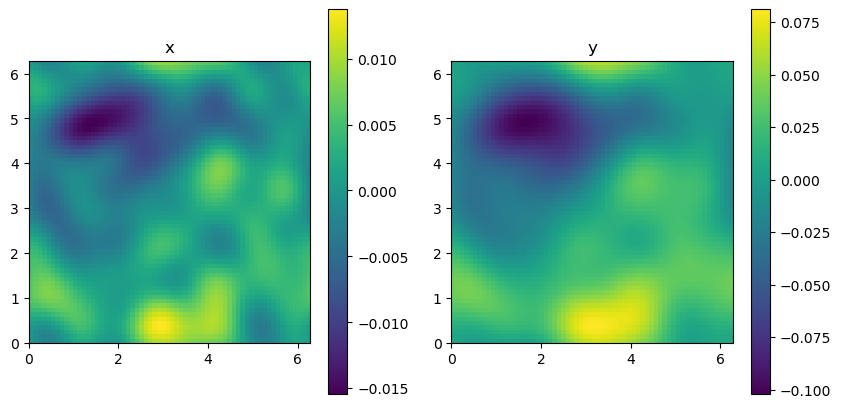

In [3]:
index_to_plot = 12

# print(len(x_train), x_train.shape, x_train[1].shape, y_train.shape)
# print(len(x_test), x_test.shape, x_test[1].shape, y_test.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[0].set_title("x")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[1].set_title("y")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
plt.show()

In [72]:
import sys
module_dir = '../'
if module_dir not in sys.path:
    sys.path.append(module_dir)
from models import *
import gpjax as gpx

class full_model():
    def __init__(self, n, m, ARD, multiinput, standardise):
        self.n = n
        self.m = m
        self.ARD = ARD
        self.multiinput = multiinput
        self.standardise = standardise

    def fit(self, x_train, y_train, n_samples = None):

        if self.ARD:
            ls = jnp.full(self.n, 2, dtype=jnp.float64)
            var = jnp.full(self.n, 2, dtype=jnp.float64)
        else:
            ls = jnp.full((1), 2, dtype=jnp.float64)
            var = jnp.full((1), 2, dtype=jnp.float64)

        GP_params = {"kernel": gpx.kernels.RBF(lengthscale = ls, variance = jnp.full((1), 1, dtype=jnp.float64)), 'mean_function': gpx.mean_functions.Zero(), 'multiinput': self.multiinput}

        self.x_train = x_train
        self.y_train = y_train

        if self.m is None:
            self.m = self.y_train.shape[-1]

        self.x_pca = PCA(n_components = self.n)
        self.y_pca = PCA(n_components = self.m)
        self.x_train_pca = self.x_pca.fit_transform(self.x_train)
        print('does x pca')
        self.y_train_pca = self.y_pca.fit_transform(self.y_train)
        print('does y pca')

        self.model_list = []

        if n_samples is not None:
            train_samples_pca = np.zeros((x_train.shape[0], self.m, n_samples))
            train_samples = np.zeros((self.y_train.shape[0], self.y_train.shape[1], n_samples))

        if self.standardise:
            self.x_train_pca_stand = (self.x_train_pca - self.x_train_pca.mean(axis = 0))/self.x_train_pca.std(axis = 0)
            self.y_train_pca_stand = (self.y_train_pca - self.y_train_pca.mean(axis = 0))/self.y_train_pca.std(axis = 0)

            if self.multiinput:
                for i in tqdm(range(self.y_train_pca_stand.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca_stand, self.y_train_pca_stand[:, i])
                    print(local_gp.kernel.lengthscale)
                    print(local_gp.kernel.variance)
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca_stand, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.y_train_pca_stand.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca_stand[:, i].reshape(-1, 1), self.y_train_pca_stand[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca_stand[:, i].reshape(-1, 1), n_samples = n_samples)

        else:
            if self.multiinput:
                for i in tqdm(range(self.y_train_pca.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca, self.y_train_pca[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.y_train_pca.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca[:, i].reshape(-1, 1), self.y_train_pca[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca[:, i].reshape(-1, 1), n_samples = n_samples)

        if n_samples is not None:
            for i in range(n_samples):
                train_samples_pca_i = train_samples_pca[:, :, i]
                train_samples_i = self.y_pca.inverse_transform(train_samples_pca_i)
                train_samples[:, :, i] = train_samples_i
            return train_samples
    
    def predict(self, x_test, n_samples = None):

        self.x_test = x_test

        self.x_test_pca = self.x_pca.transform(x_test)

        if n_samples is not None:
            test_samples_pca = np.zeros((x_test.shape[0], self.m, n_samples))
            test_samples = np.zeros((self.x_test.shape[0], self.y_train.shape[1], n_samples))
        
        if self.standardise:
            y_pred_pca_stand = []
            self.x_test_pca_stand = (self.x_test_pca - self.x_train_pca.mean(axis = 0))/self.x_train_pca.std(axis = 0)
            if self.multiinput:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca_stand.append(local_gp.predict(self.x_test_pca_stand))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca_stand, n_samples = n_samples)
                        test_samples_pca[:, i, :] = (test_samples_pca[:, i, :] * self.y_train_pca.std(axis = 0)[i]) + self.y_train_pca.mean(axis = 0)[i]
            
            else:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca_stand.append(local_gp.predict(self.x_test_pca_stand[:, i].reshape(-1, 1)))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca_stand[:, i].reshape(-1, 1), n_samples = n_samples)
                        test_samples_pca[:, i, :] = (test_samples_pca[:, i, :] * self.y_train_pca.std(axis = 0)[i]) + self.y_train_pca.mean(axis = 0)[i]
            
            y_pred_pca_stand = np.stack(y_pred_pca_stand).T
            self.y_pred_pca = (y_pred_pca_stand * self.y_train_pca.std(axis = 0)) + self.y_train_pca.mean(axis = 0)
        
        else:
            self.y_pred_pca = []
            if self.multiinput:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    self.y_pred_pca.append(local_gp.predict(self.x_test_pca))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    self.y_pred_pca.append(local_gp.predict(self.x_test_pca[:, i].reshape(-1, 1)))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca[:, i].reshape(-1, 1), n_samples = n_samples)
            
            self.y_pred_pca = np.stack(self.y_pred_pca).T
        
        y_pred = self.y_pca.inverse_transform(self.y_pred_pca)

        if n_samples is not None:
            for i in range(n_samples):
                test_samples_pca_i = test_samples_pca[:, :, i]
                test_samples_i = self.y_pca.inverse_transform(test_samples_pca_i)
                test_samples[:, :, i] = test_samples_i
            return y_pred[:, 0, :], test_samples
        else:
            return y_pred[:, 0, :]

In [73]:
# determine n
# x_pca = PCA(n_components=x_train.shape[-1])
# x_train_pca = x_pca.fit_transform(x_train)

# plt.plot(np.cumsum(x_pca.explained_variance_ratio_))
# plt.show()

# n = np.where(np.cumsum(x_pca.explained_variance_ratio_) > 0.95)[0][0]

# # determine m
# y_pca = PCA(n_components=y_train.shape[-1])
# y_train_pca = y_pca.fit_transform(y_train)

# plt.plot(np.cumsum(y_pca.explained_variance_ratio_))
# plt.show()

# m = np.where(np.cumsum(y_pca.explained_variance_ratio_) > 0.99)[0][0]

# print(n, m)

# Train

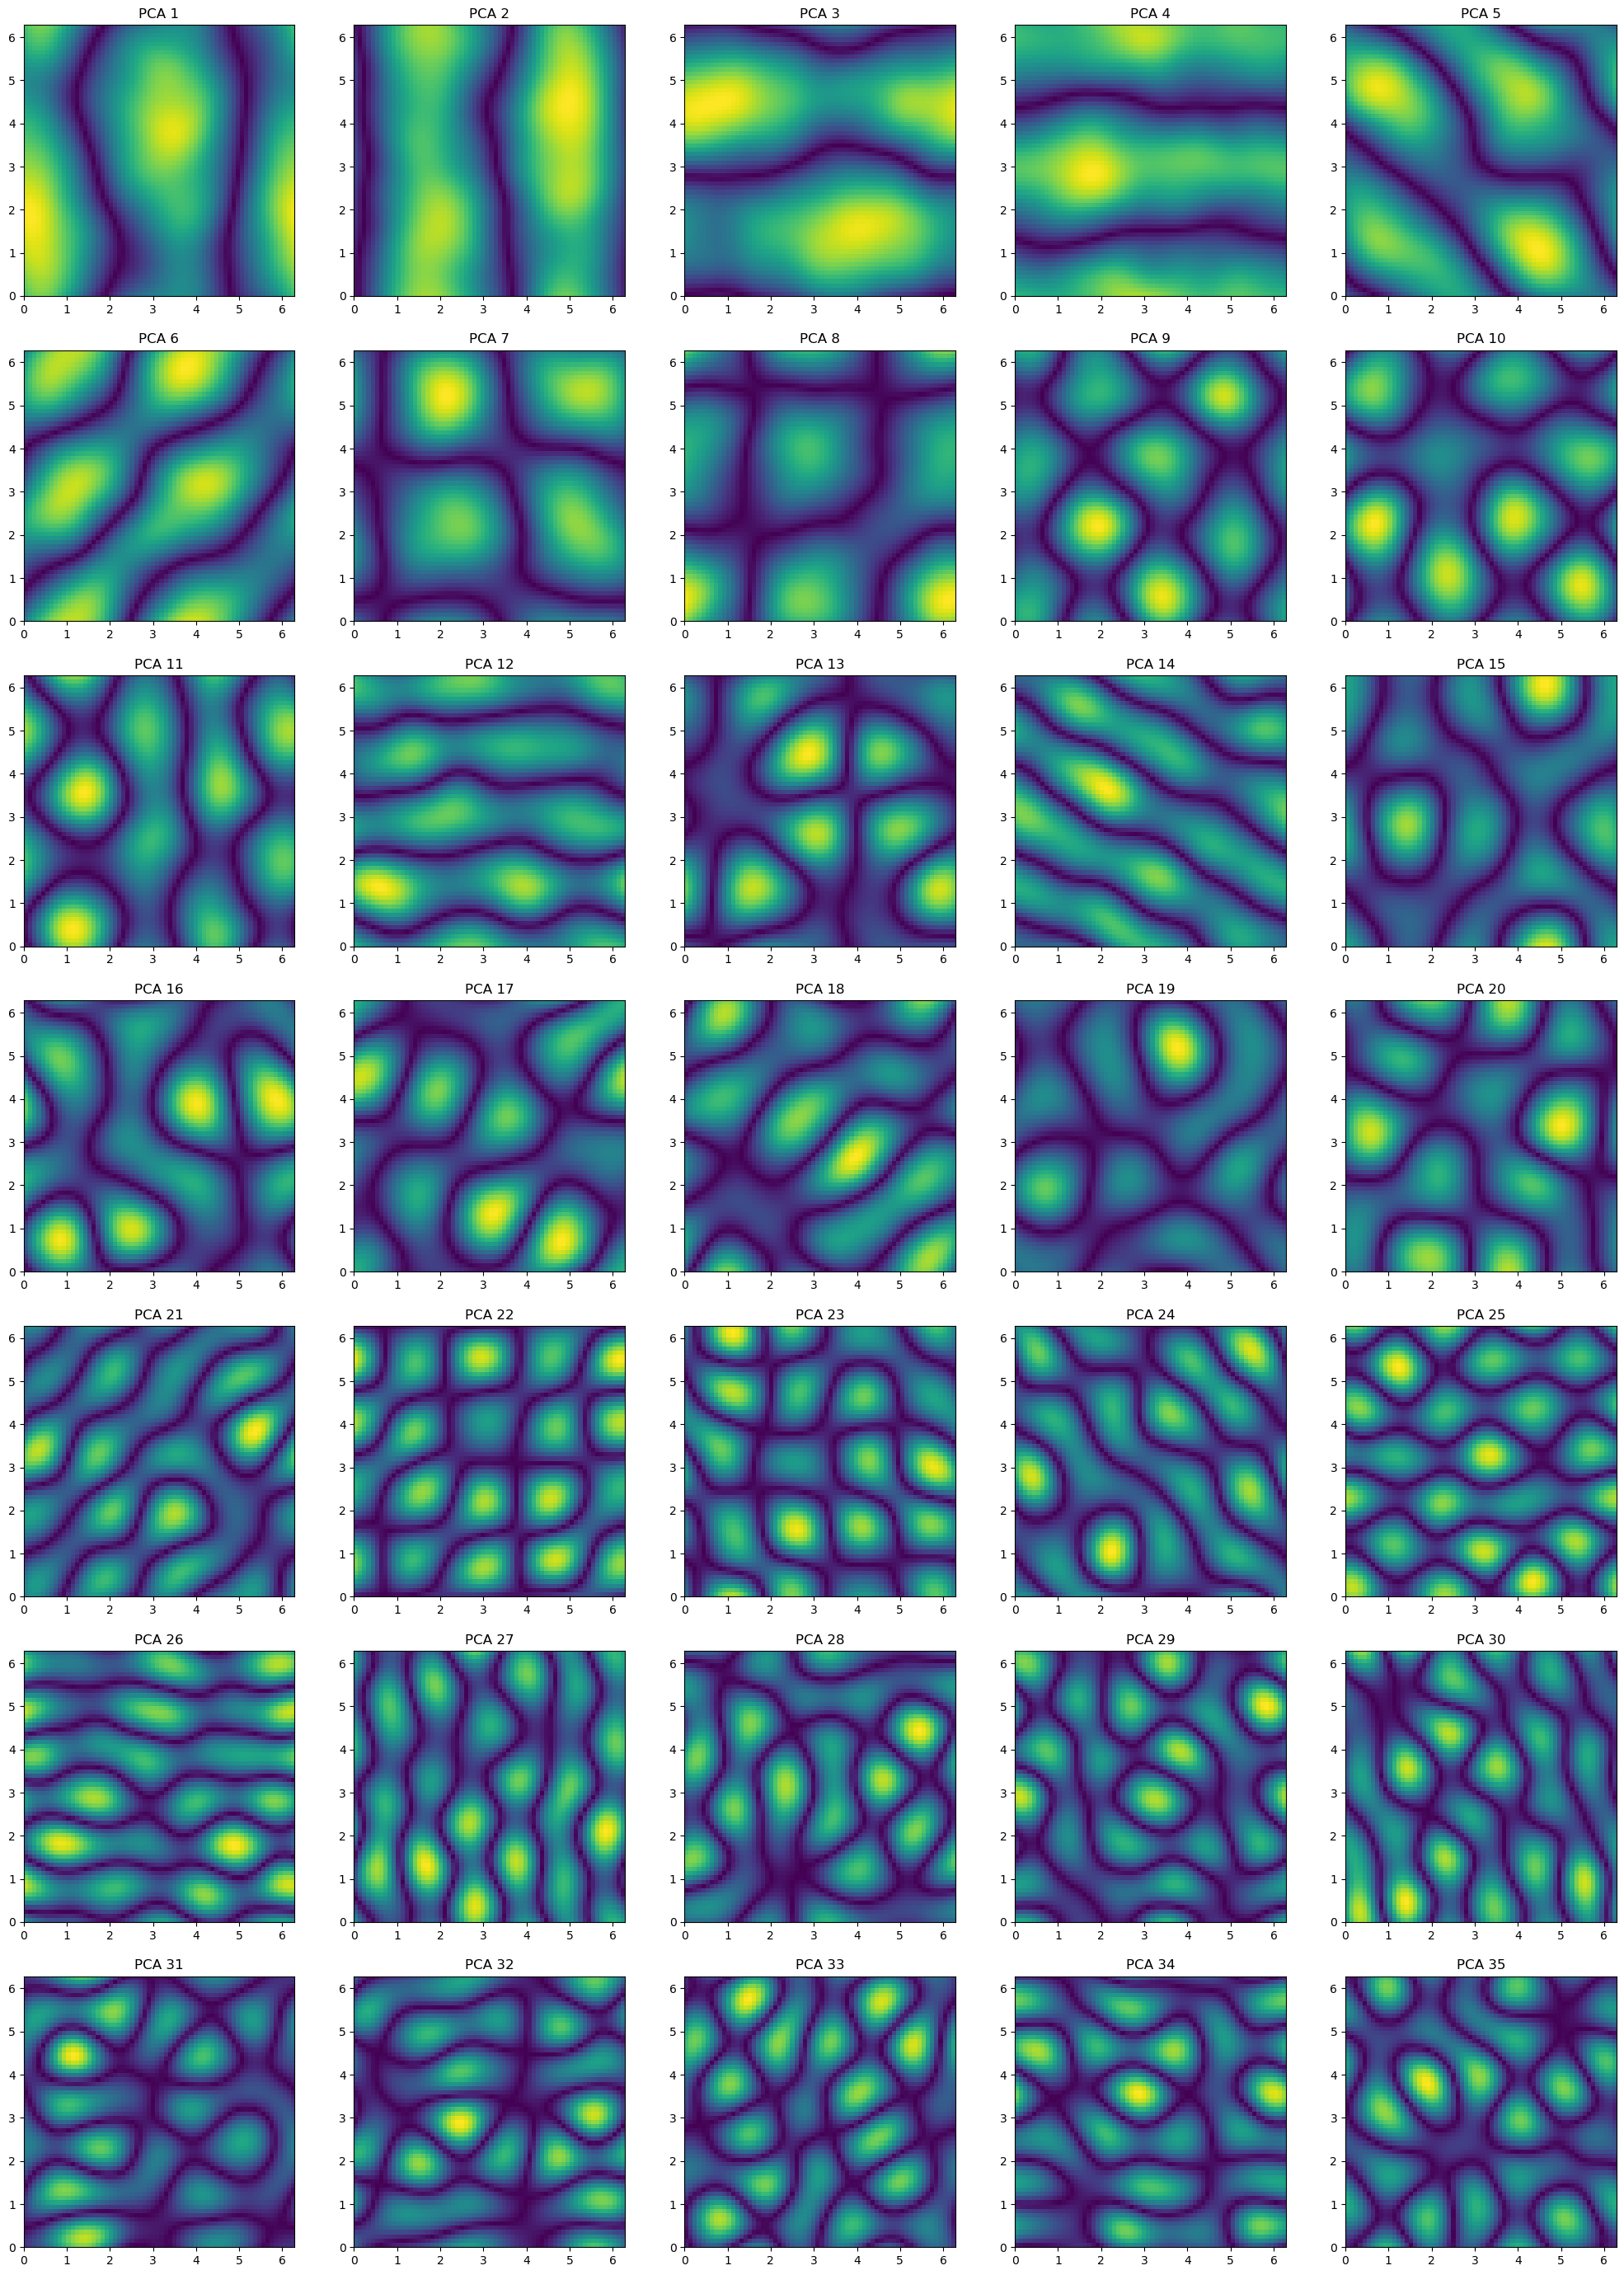

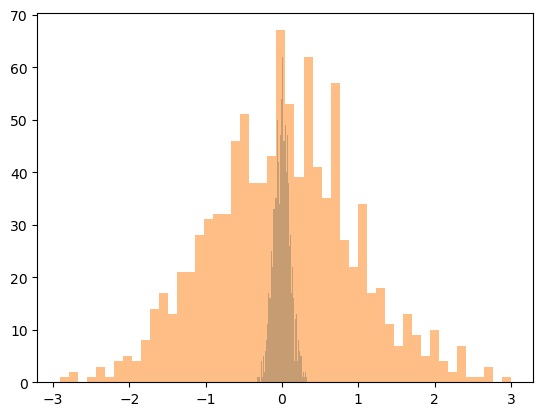

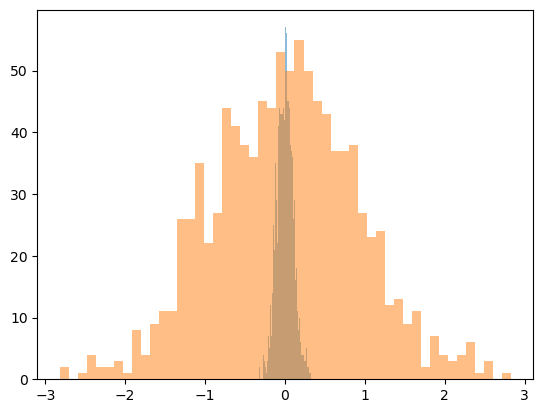

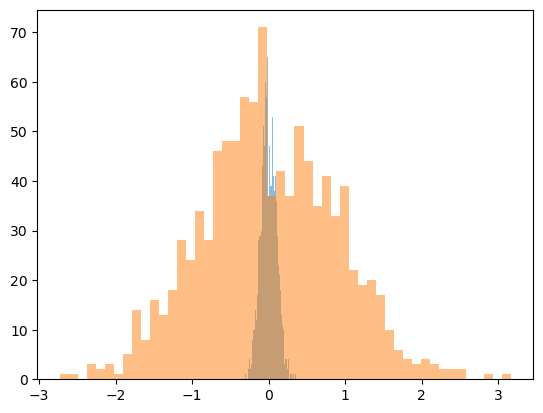

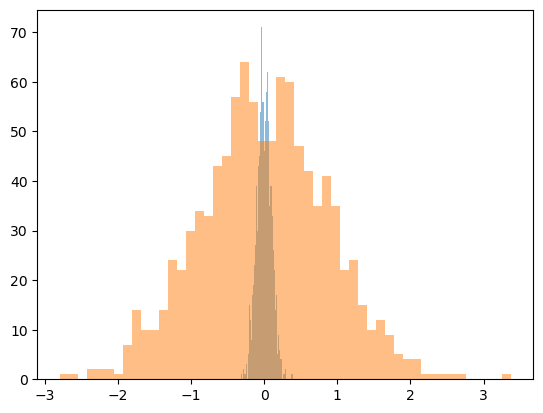

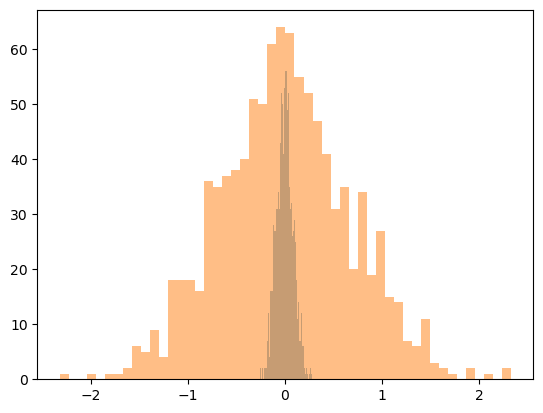

standardising


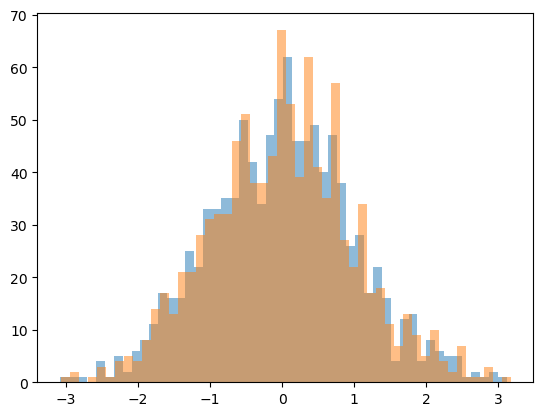

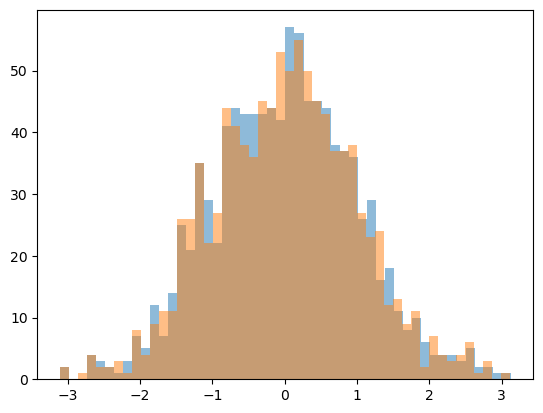

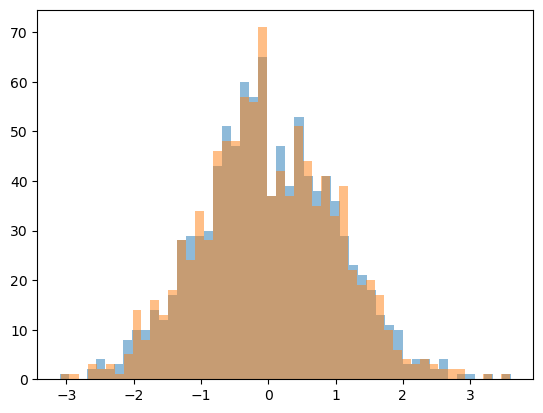

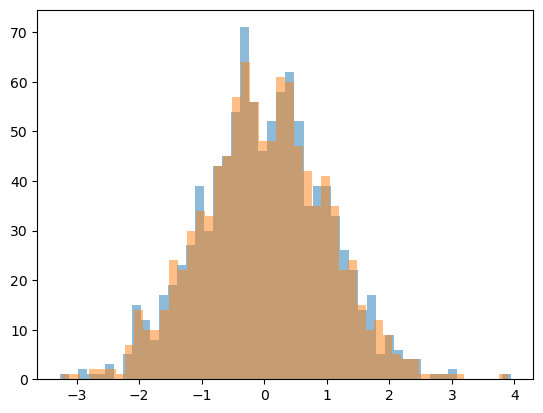

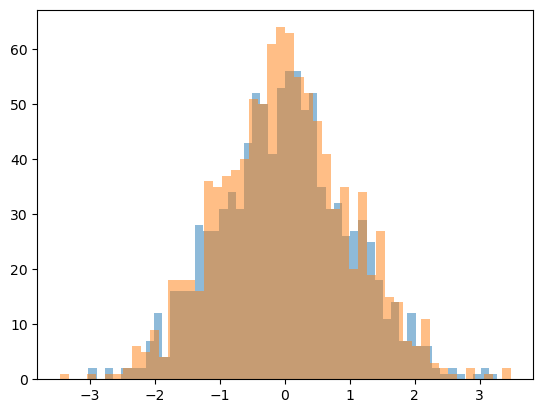

In [74]:
x_train_pca = PCA(n_components=45).fit(x_train)
y_train_pca = PCA(n_components=35).fit(y_train)

fig, ax = plt.subplots(7, 10, figsize=(25, 70))
ax = ax.flatten()

for i in range(0, 35, 2):
    ax[i].imshow(np.abs(x_train_pca.components_[i, :]).reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
    ax[i].set_title(f"x PCA {i+1}")
    ax[i+1].imshow(np.abs(y_train_pca.components_[i, :]).reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
    ax[i+1].set_title(f"y PCA {i+1}")
plt.show()

x_train_pca = x_train_pca.transform(x_train)
y_train_pca = y_train_pca.transform(y_train)

for i in range(5):
    plt.figure()
    plt.hist(x_train_pca[:, i], bins=50, label = f'x_train_pca {i+1}', alpha=0.5)
    plt.hist(y_train_pca[:, i], bins=50, label = f'y_train_pca {i+1}', alpha=0.5)
    plt.show()

print('standardising')

for i in range(5):
    x_train_pca_stand_i = (x_train_pca[:, i] - x_train_pca[:, i].mean(axis = 0))/x_train_pca[:, i].std(axis = 0)
    y_train_pca_stand_i = (y_train_pca[:, i] - y_train_pca[:, i].mean(axis = 0))/y_train_pca[:, i].std(axis = 0)
    plt.figure()
    plt.hist(x_train_pca_stand_i, bins=50, label = f'x_train_pca_stand {i+1}', alpha=0.5)
    plt.hist(y_train_pca_stand_i, bins=50, label = f'y_train_pca_stand {i+1}', alpha=0.5)
    plt.show()



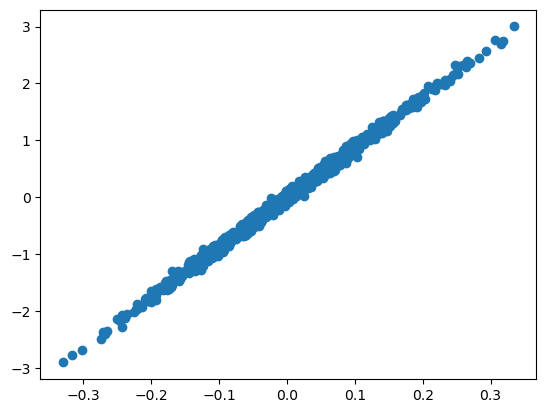

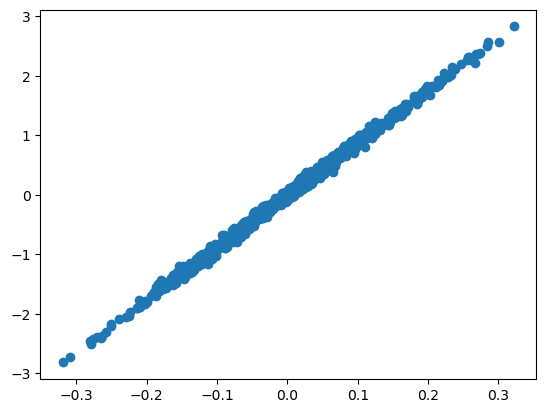

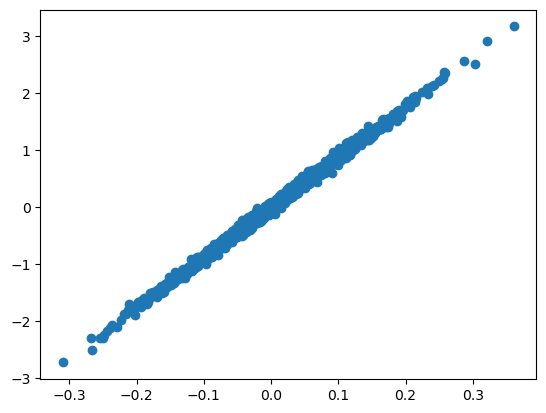

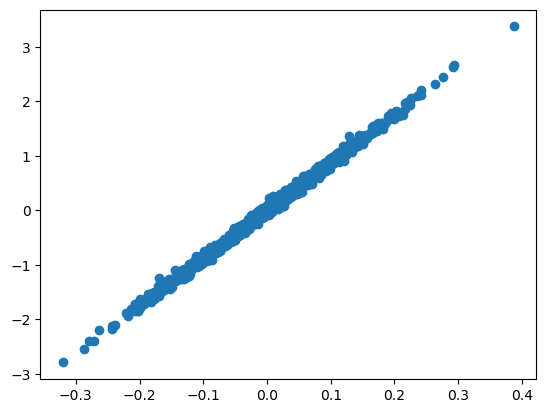

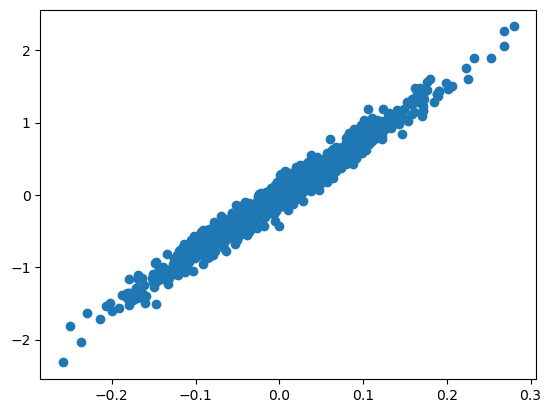

In [75]:
for i in range(5):
    plt.figure()
    plt.plot(x_train_pca[:, i], y_train_pca[:, i], 'o')
    plt.show()

In [76]:
## Train

n, m = 45, 5 # n, m = 45, 35 for variance explained 0.95, 0.99

n_samples = 6

model = full_model(n = n, m = m, ARD = False, multiinput = True, standardise = True)
train_samples = model.fit(x_train, y_train, n_samples = None)

does x pca
does y pca


  0%|          | 0/5 [00:00<?, ?it/s]

[1.]
float64


 20%|██        | 1/5 [00:41<02:47, 41.93s/it]

Optimization terminated successfully.
         Current function value: -2281.267039
         Iterations: 52
         Function evaluations: 59
         Gradient evaluations: 59
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([61.84786585], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00171523], dtype=float64))
[2.]
[1.]
[1.]
float64


 40%|████      | 2/5 [01:14<01:49, 36.37s/it]

Optimization terminated successfully.
         Current function value: -2257.153304
         Iterations: 37
         Function evaluations: 44
         Gradient evaluations: 44
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([60.74498544], dtype=float64), variance=Array([9.99999999], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00114294], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 60%|██████    | 3/5 [02:22<01:41, 50.73s/it]

         Current function value: -2195.371230
         Iterations: 50
         Function evaluations: 124
         Gradient evaluations: 112
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([59.75097536], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0034191], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 80%|████████  | 4/5 [03:22<00:54, 54.55s/it]

         Current function value: -2167.960765
         Iterations: 50
         Function evaluations: 99
         Gradient evaluations: 88
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([58.54971061], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0030114], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
100%|██████████| 5/5 [04:07<00:00, 49.58s/it]

         Current function value: -2104.507813
         Iterations: 24
         Function evaluations: 80
         Gradient evaluations: 72
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([56.25831899], dtype=float64), variance=Array([9.99999524], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00286115], dtype=float64))
[2.]
[1.]


In [77]:
n_samples = 6

y_pred_train, train_samples = model.predict(x_train, n_samples = n_samples)

print(train_samples.shape)

relative_L2 = np.linalg.norm(y_pred_train - y_train, axis = -1)/np.linalg.norm(y_train, axis = -1)

print(f'median relative L2 (train data): {np.median(relative_L2)}')
print(f'mean relative L2 (train data): {np.mean(relative_L2)}')

100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


(1000, 4096, 6)
median relative L2 (train data): 0.6703276289516233
mean relative L2 (train data): 0.6708020198000743


(1000, 4096, 6)


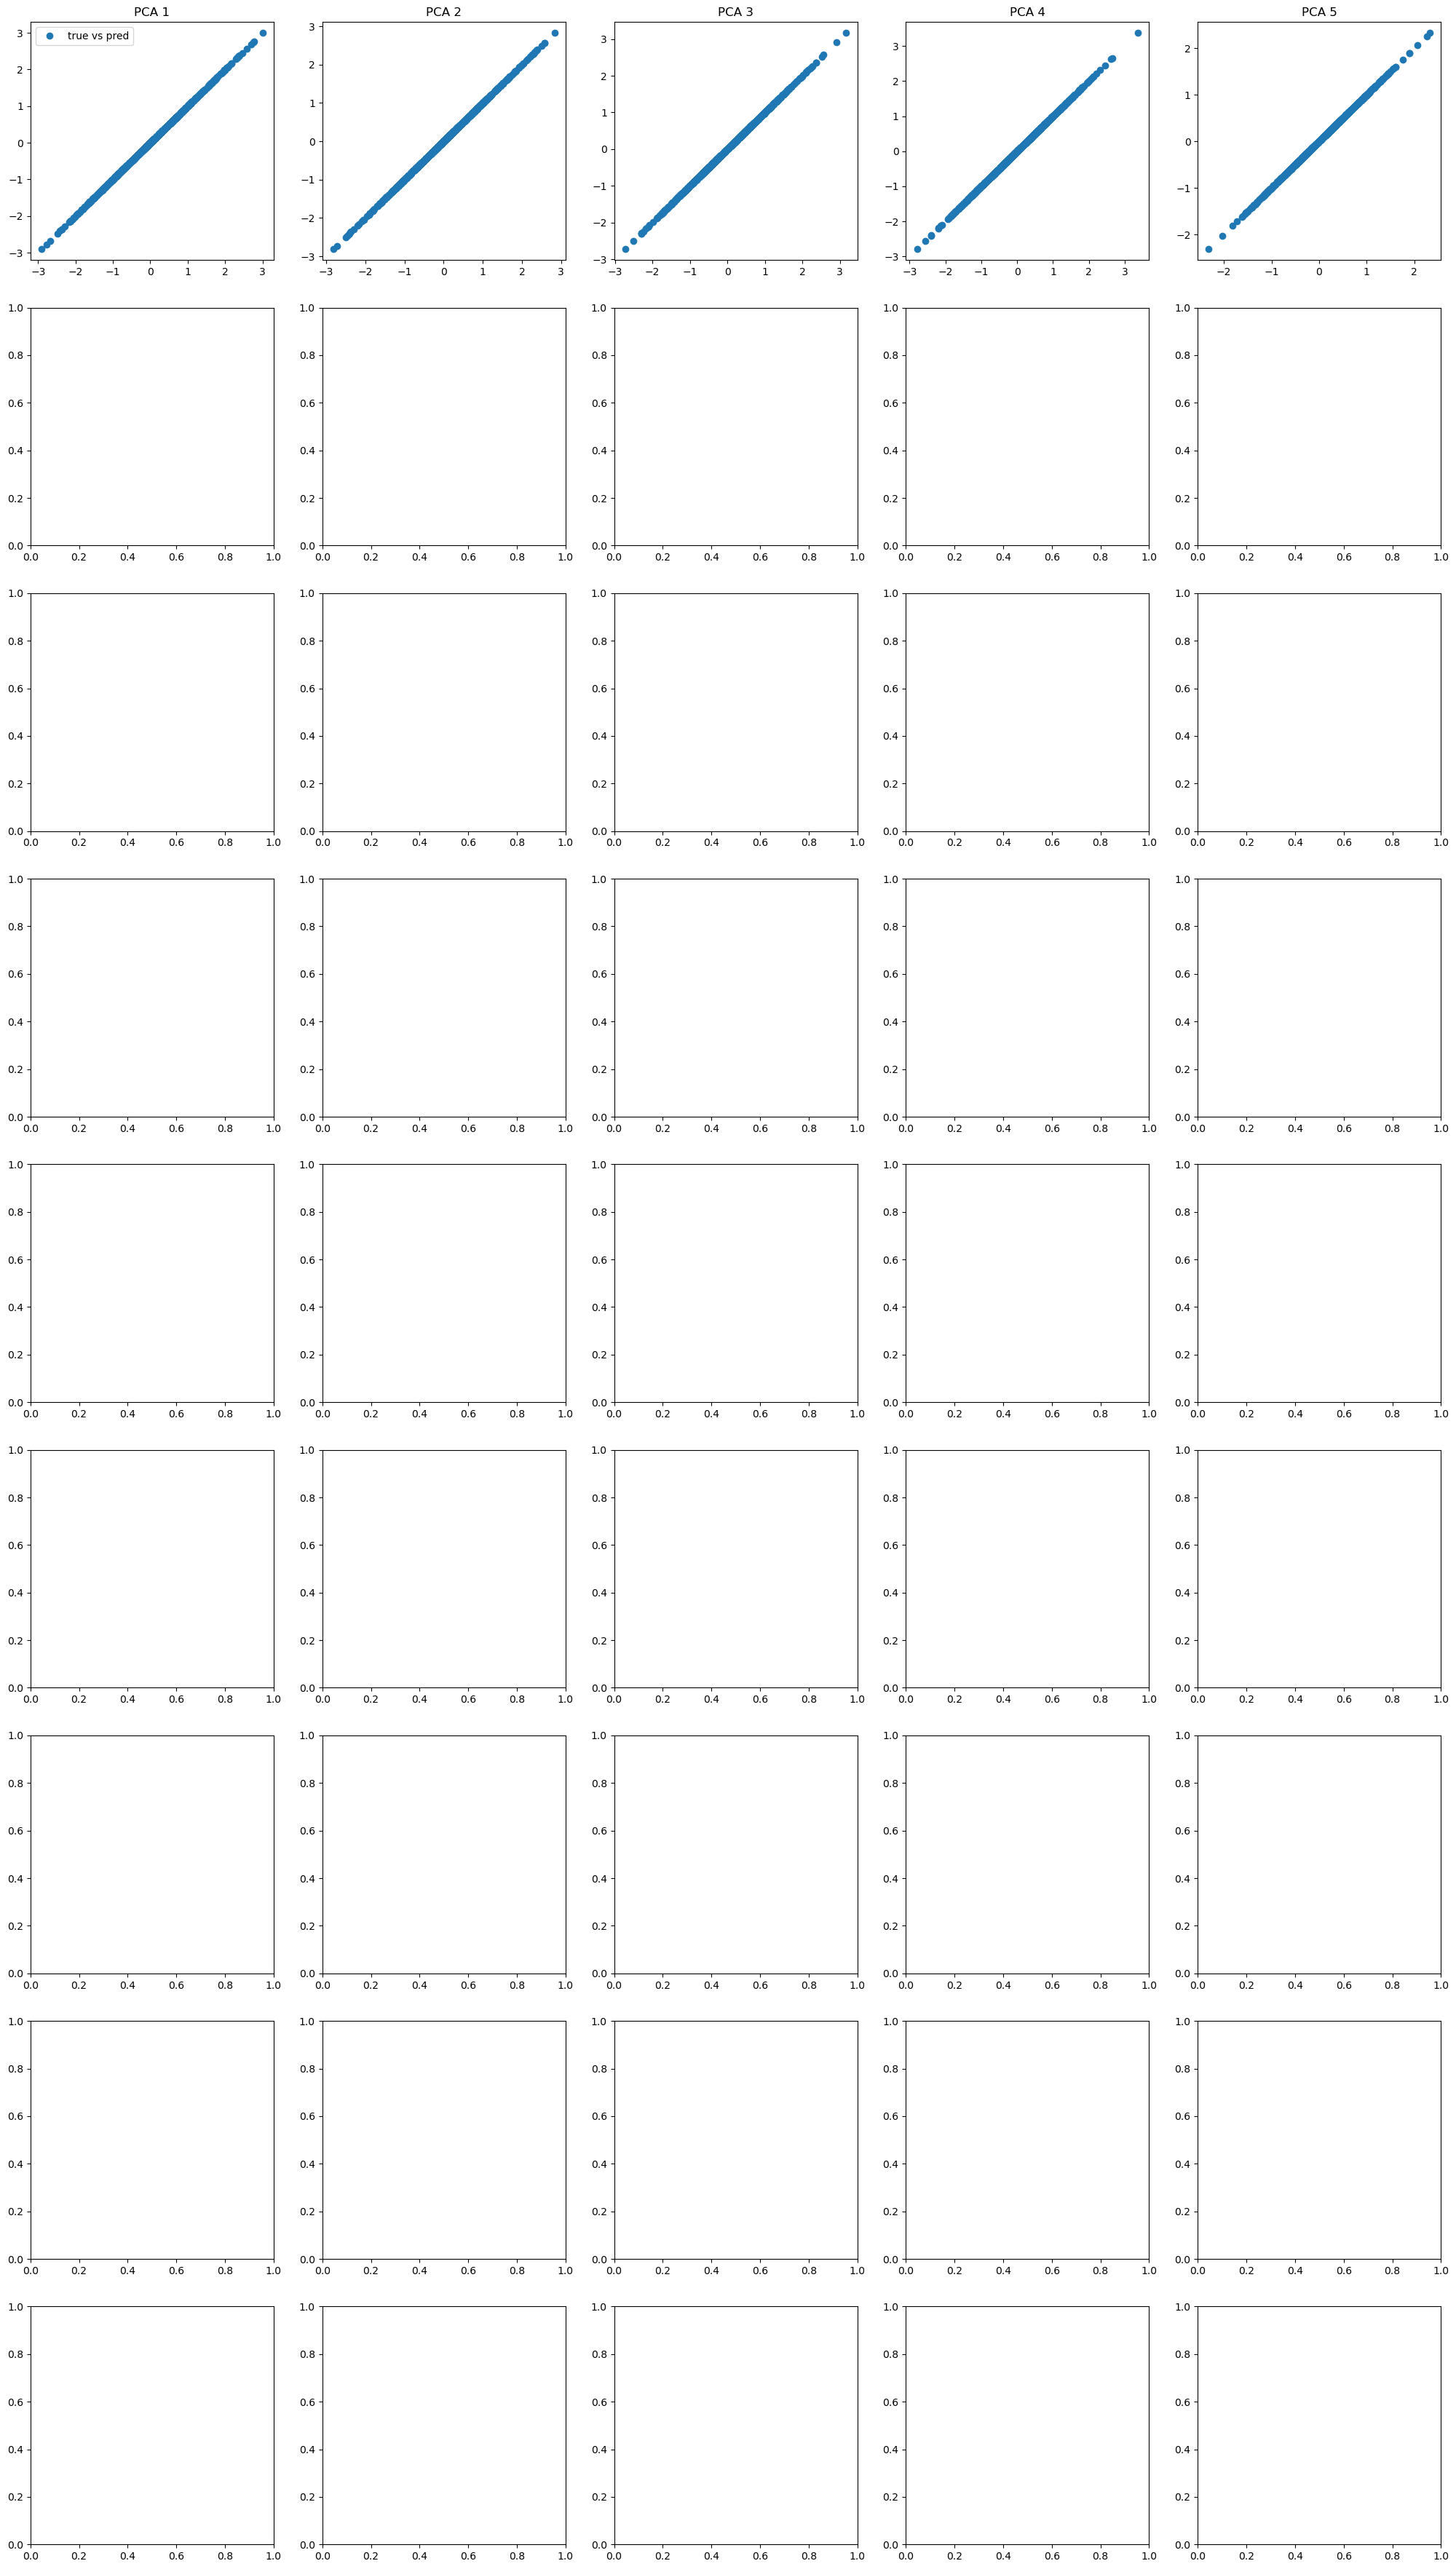

In [78]:
x_train_pca = model.x_test_pca
y_train_pca = model.y_pca.transform(y_train)

fig, ax = plt.subplots(9, 5, figsize=(25, 45))
ax = ax.flatten()

print(train_samples.shape)

for i in range(m):
    # ax[i].plot(x_train_pca[:, i], y_train_pca[:, i], 'o', label = 'true')
    # ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(x_train_pca[:, i])], '-', label = 'pred', lw = 4)
    # for j in range(n_samples):
    #     train_samples_pca_j = train_samples[:, :, j]
    #     train_samples_j = model.y_pca.transform(train_samples_pca_j)
    #     ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], train_samples_j[:, i][np.argsort(train_samples_j[:, i])], '-', label = f'sample {j+1}')
    ax[i].plot(y_train_pca[:, i], model.y_pred_pca[:, 0, i], 'o', label = 'true vs pred')
    ax[i].set_title(f'PCA {i+1}')
ax[0].legend()
plt.show()

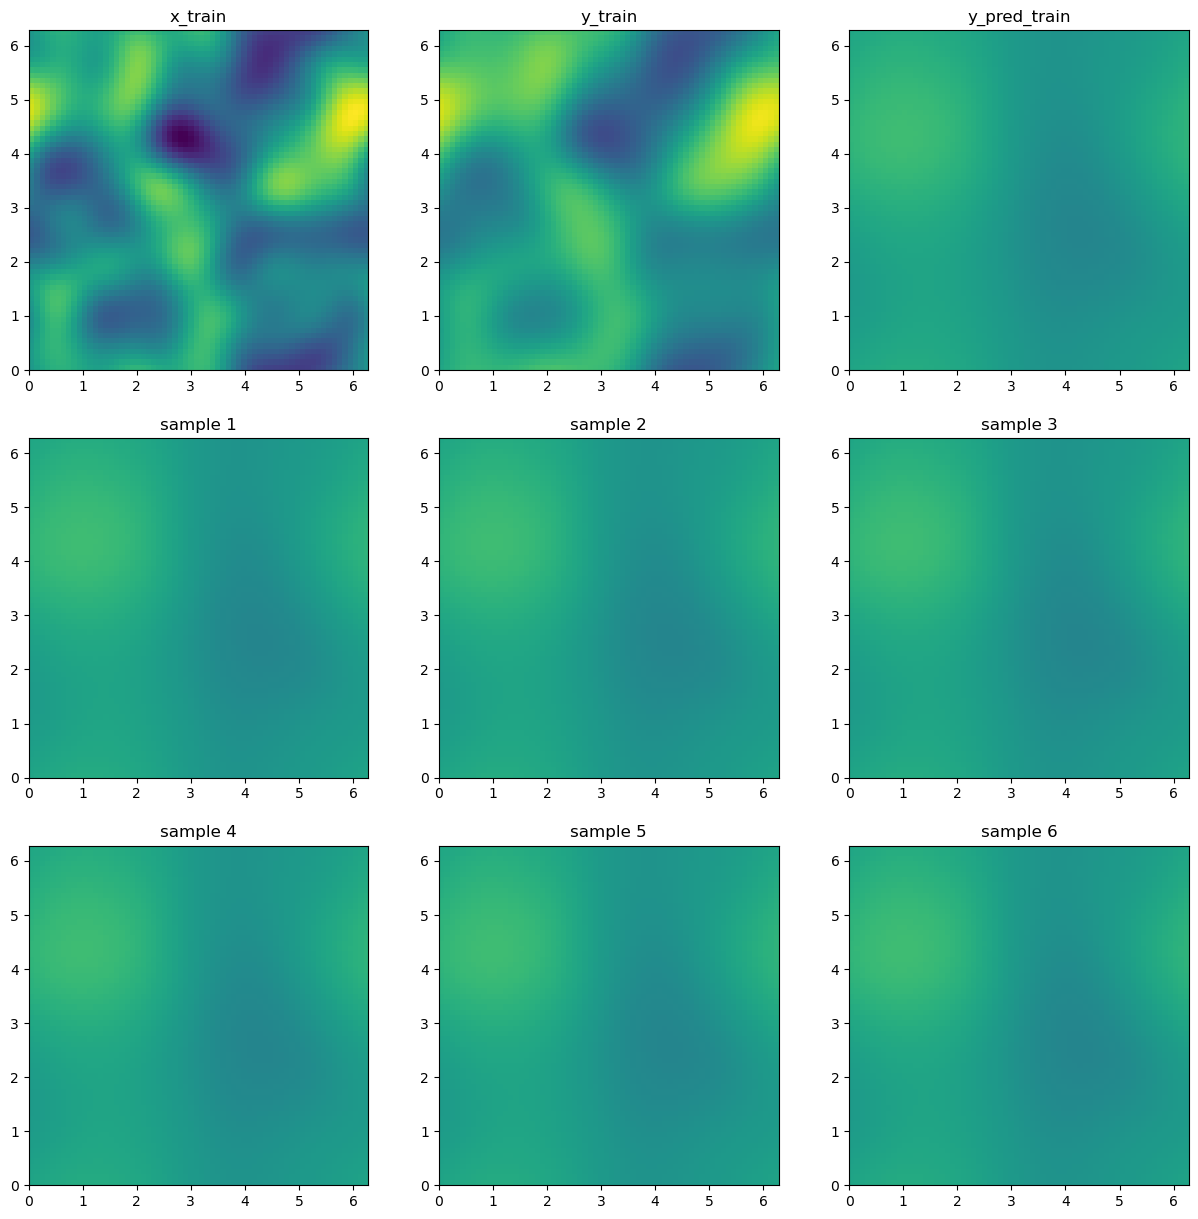

In [79]:
index_to_plot = 127

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_train[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_train[index_to_plot, :].max())])

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[0].set_title("x_train")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title("y_train")
im2 = ax[2].imshow(y_pred_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[2].set_title("y_pred_train")
for i in range(6):
    imi = ax[i+3].imshow(train_samples[index_to_plot, :, i].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
    ax[i+3].set_title(f"sample {i+1}")
    
            # ax[i].legend()
plt.show()

# testing

In [80]:
n_samples = 100

y_pred_test, test_samples = model.predict(x_test, n_samples = n_samples)

relative_L2 = np.linalg.norm(y_pred_test - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1)

print(f'median relative L2: {np.median(relative_L2)}')
print(f'mean relative L2: {np.mean(relative_L2)}')

100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


median relative L2: 0.6645384987429312
mean relative L2: 0.670211785939353


(1000, 4096, 6)


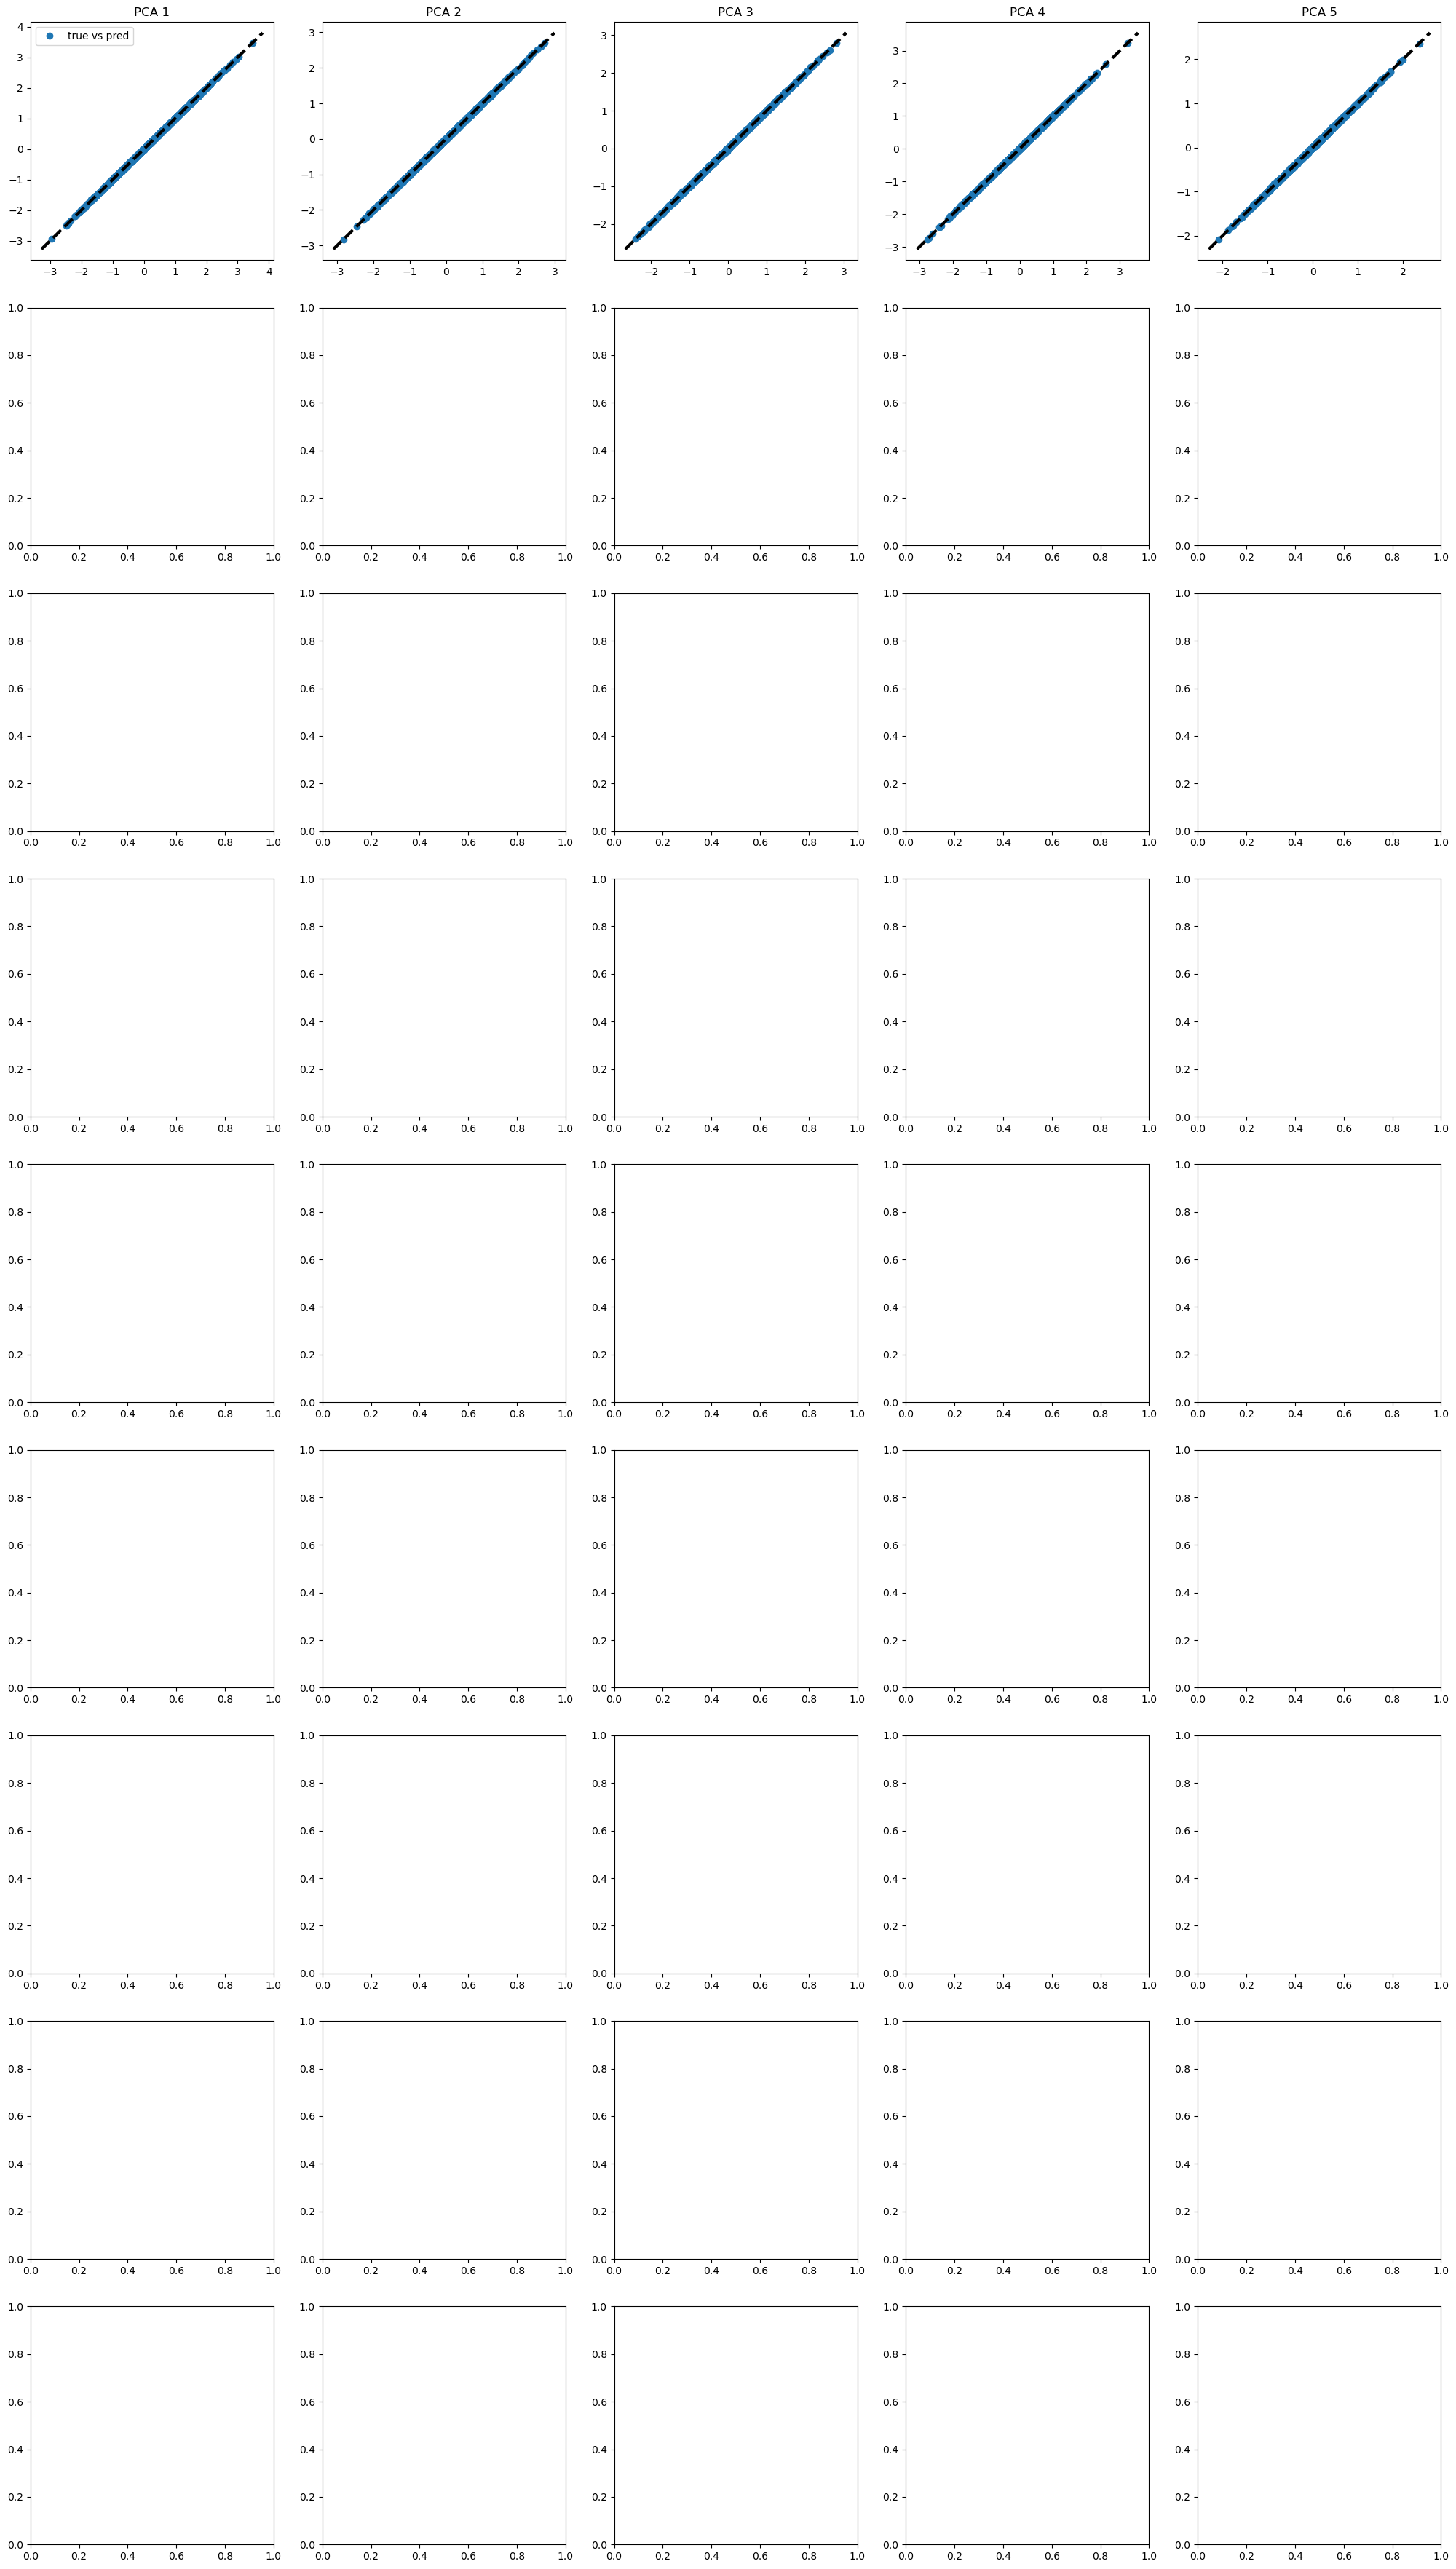

In [81]:
x_test_pca = model.x_test_pca
y_test_pca = model.y_pca.transform(y_test)

fig, ax = plt.subplots(9, 5, figsize=(25, 45))
ax = ax.flatten()

print(train_samples.shape)

for i in range(m):
    # ax[i].plot(x_train_pca[:, i], y_train_pca[:, i], 'o', label = 'true')
    # ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(x_train_pca[:, i])], '-', label = 'pred', lw = 4)
    # for j in range(n_samples):
    #     train_samples_pca_j = train_samples[:, :, j]
    #     train_samples_j = model.y_pca.transform(train_samples_pca_j)
    #     ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], train_samples_j[:, i][np.argsort(train_samples_j[:, i])], '-', label = f'sample {j+1}')
    ax[i].plot(y_test_pca[:, i], model.y_pred_pca[:, 0, i], 'o', label = 'true vs pred')
    xlim = ax[i].get_xlim()
    ylim = ax[i].get_ylim()

    min_val = min(xlim[0], ylim[0])
    max_val = max(xlim[1], ylim[1])

    ax[i].plot([min_val, max_val], [min_val, max_val], 'k--', lw=3)
    ax[i].set_title(f'PCA {i+1}')
ax[0].legend()
plt.show()

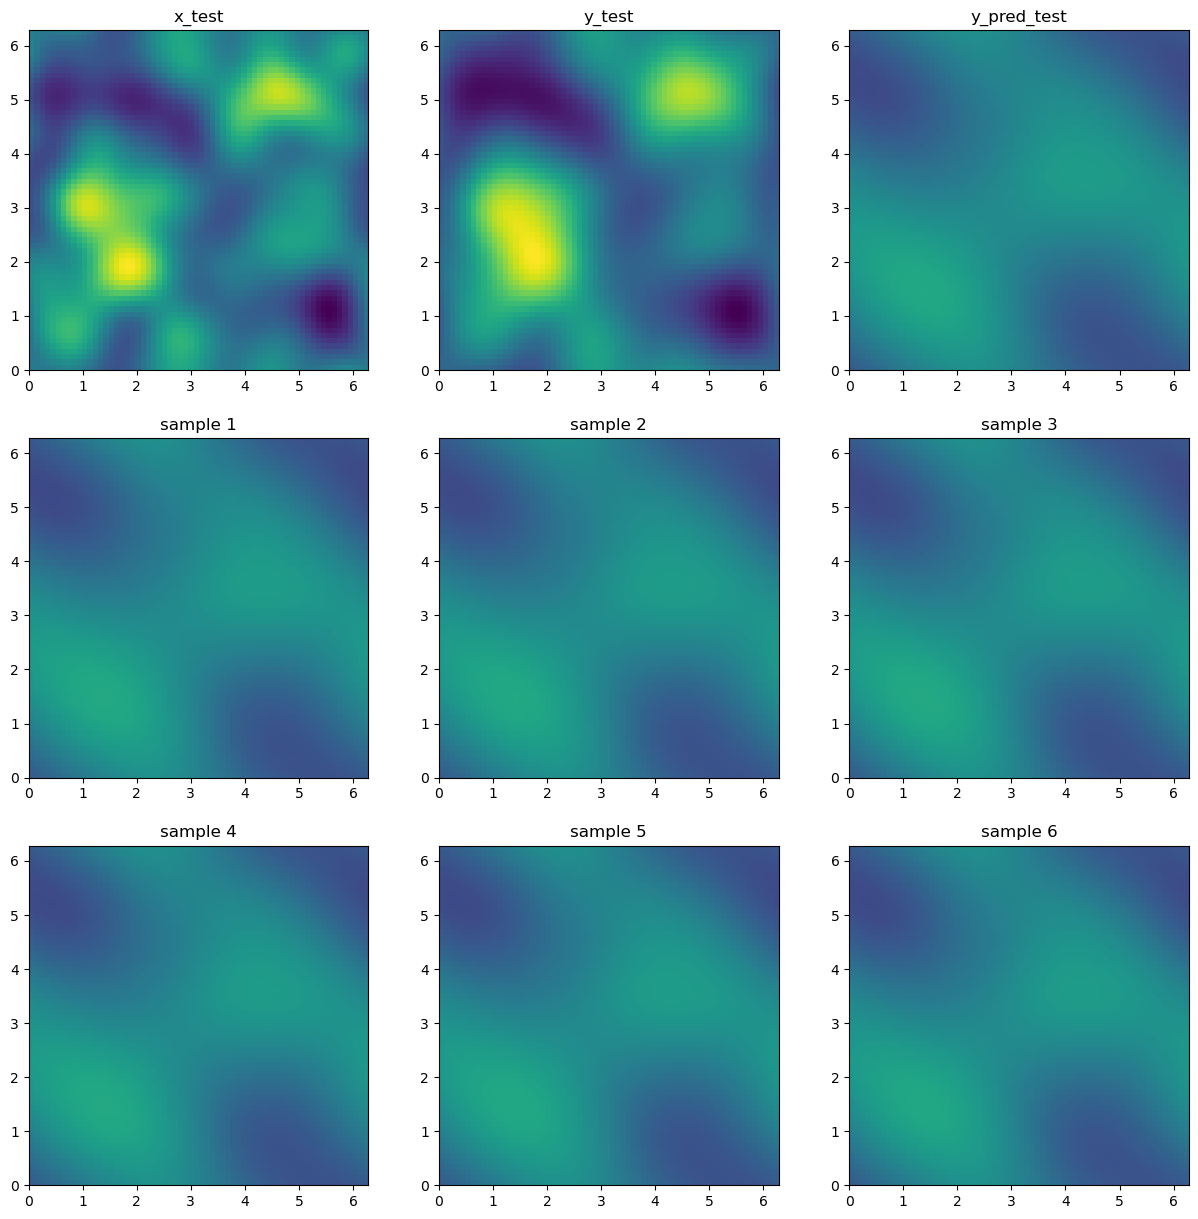

In [82]:
index_to_plot = 125

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_test[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_test[index_to_plot, :].max())])

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[0].set_title("x_test")
im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title("y_test")
im2 = ax[2].imshow(y_pred_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[2].set_title("y_pred_test")
for i in range(6):
    imi = ax[i+3].imshow(test_samples[index_to_plot, :, i].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
    ax[i+3].set_title(f"sample {i+1}")
    
            # ax[i].legend()
plt.show()

## analyse uncertainty

In [83]:
print(test_samples.shape)

test_samples_mean = np.mean(test_samples, axis = 2)
test_samples_std = np.std(test_samples, axis = 2)

(1000, 4096, 100)


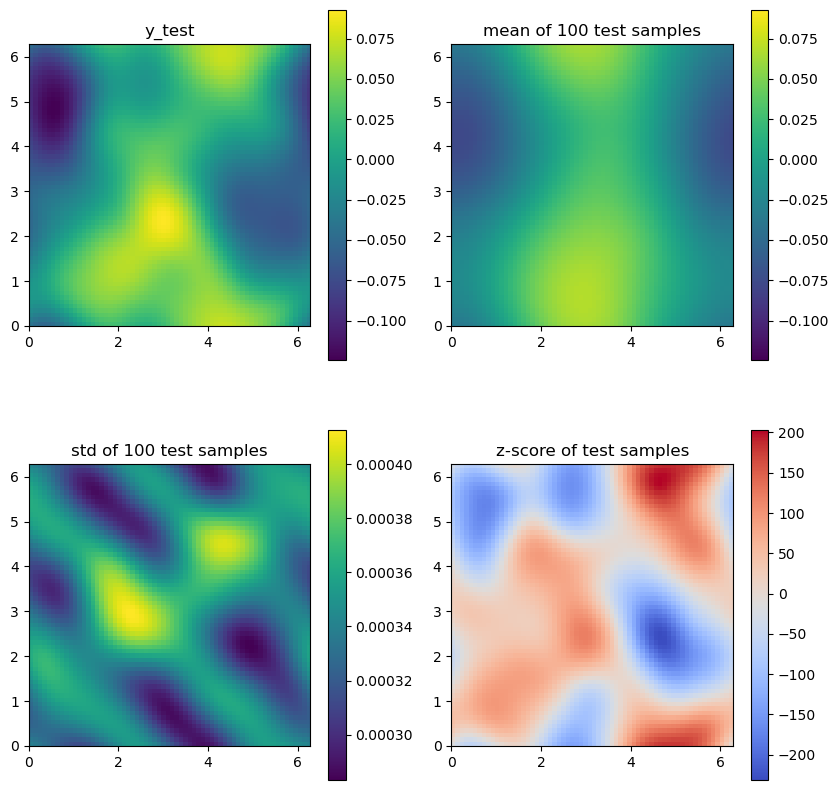

In [84]:
index_to_plot = 126

y_lims = np.array([min(y_test[index_to_plot, :].min(), test_samples_mean[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), test_samples_mean[index_to_plot, :].max())])

fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax = ax.flatten()

im0 = ax[0].imshow(y_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[0].set_title("y_test")
im1 = ax[1].imshow(test_samples_mean[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title(f"mean of {n_samples} test samples")
im2 = ax[2].imshow(test_samples_std[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[2].set_title(f"std of {n_samples} test samples")
im3 = ax[3].imshow((y_test[index_to_plot, :].reshape(64, 64) - test_samples_mean[index_to_plot, :].reshape(64, 64)) / test_samples_std[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], cmap = 'coolwarm')
ax[3].set_title(f"z-score of test samples")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
fig.colorbar(im2, ax=ax[2])
fig.colorbar(im3, ax=ax[3])


Linear regression baseline

1000 128
0.05201378699066556 0.05782582923690071


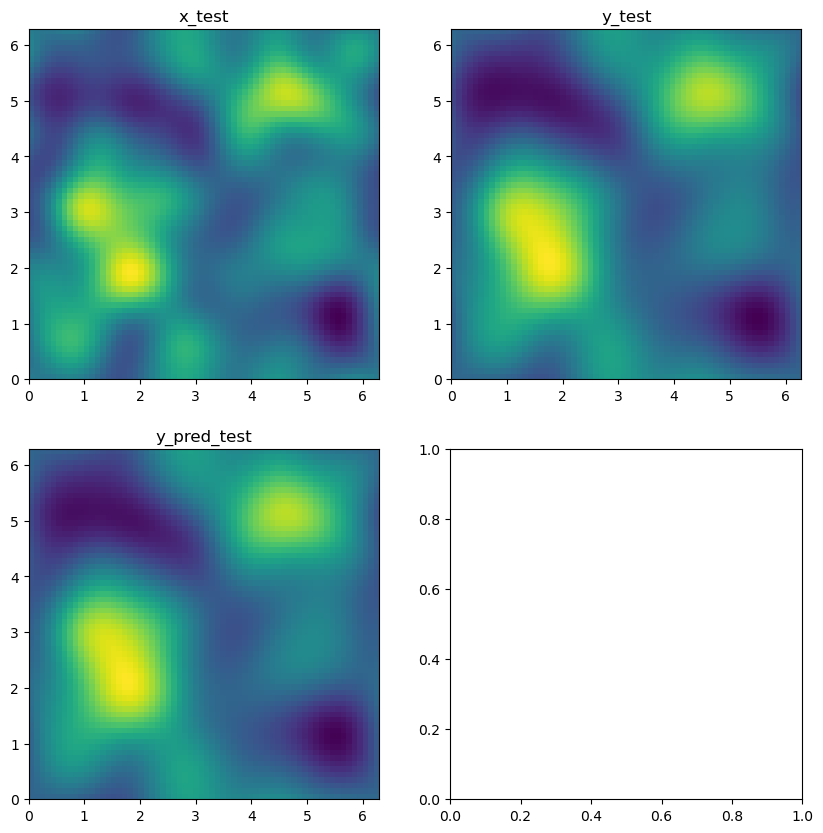

1000 256
0.05201402860957249 0.05782588731209452


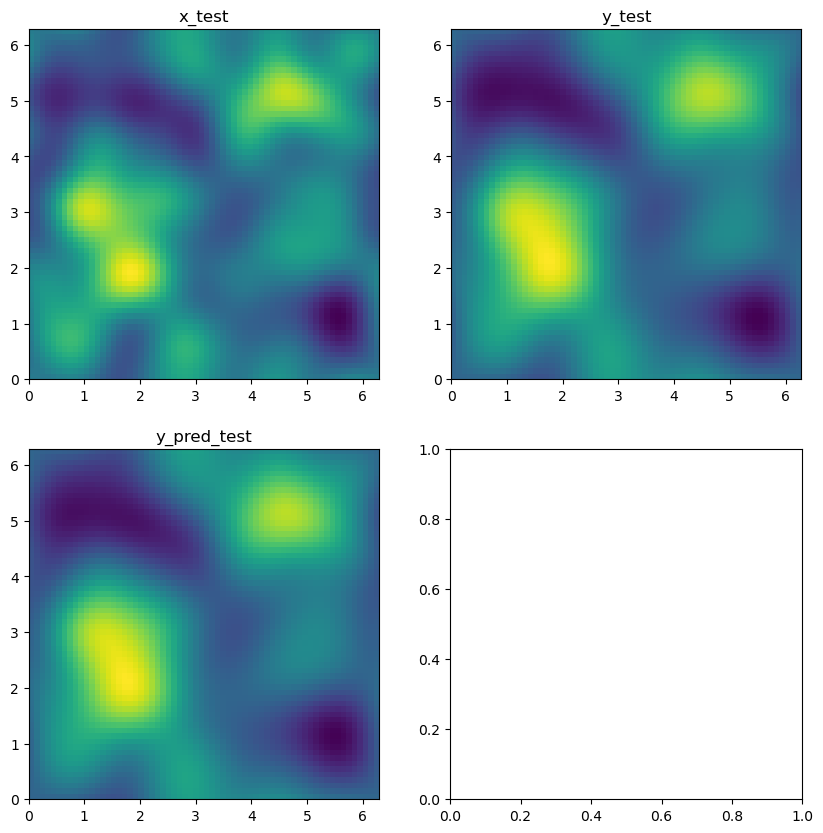

1000 512
0.05201346890222665 0.05782593226703399


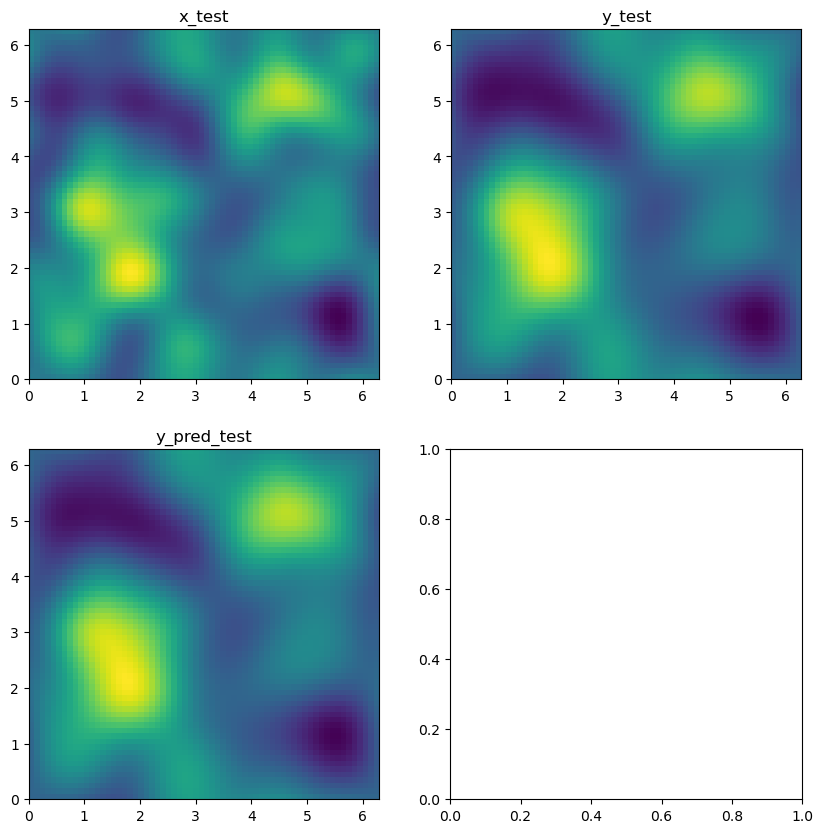

1000 1024
0.051470239119434616 0.0588309934177186


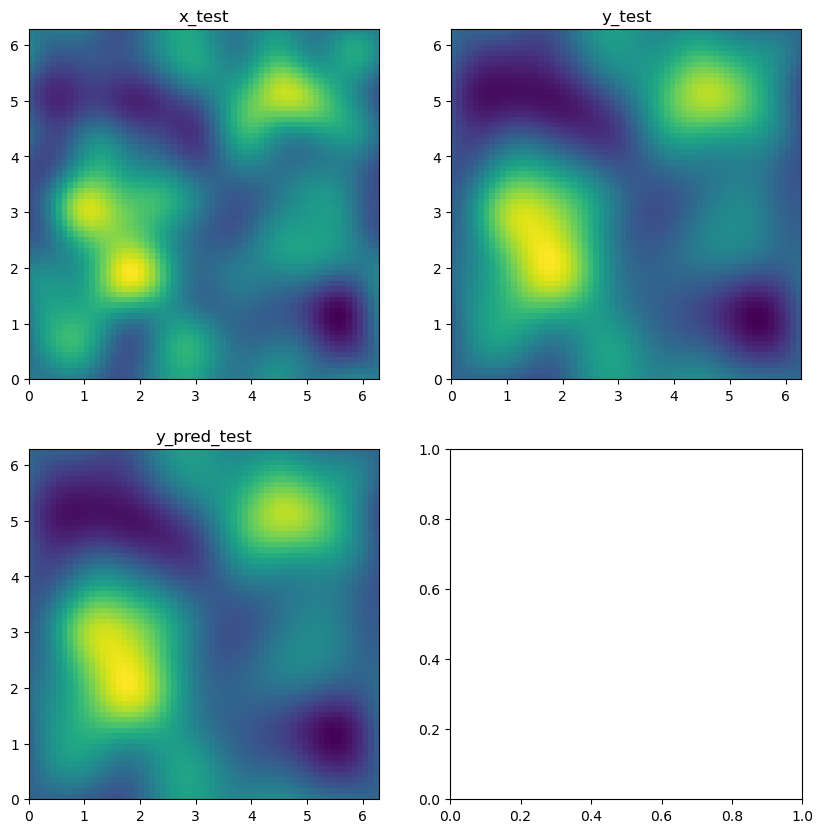

In [48]:
results = []
for Ntrain in [1000]:
    for N_components in [128, 256, 512, 1024]:
        print(Ntrain, N_components)
        Ytr = y_train
        Xtr = x_train
        pca = PCA(n_components=min(N_components,Ntrain))
        Xtr = pca.fit_transform(Xtr)
        reg = LinearRegression(n_jobs = -1).fit(Xtr, Ytr)
        #Ypred Ypredtr = reg.predict(Xtr)
        Ypredtr = reg.predict(Xtr)
        train_error = np.mean(np.linalg.norm(Ypredtr-Ytr, axis = 1)/np.linalg.norm(Ytr, axis = 1))
        Xtest = x_test
        Ytest = y_test
        Xtest = pca.transform(Xtest)
        Ypred = reg.predict(Xtest)
        test_error = np.mean(np.linalg.norm(Ypred-Ytest, axis = 1)/np.linalg.norm(Ytest, axis = 1))
        print(train_error, test_error)
        results.append([Ntrain, N_components, train_error, test_error])

        index_to_plot = 125

        y_lims = np.array([min(y_test[index_to_plot, :].min(), Ypred[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), Ypred[index_to_plot, :].max())])

        fig, ax = plt.subplots(2, 2, figsize = (10, 10))
        ax = ax.flatten()
        im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
        ax[0].set_title("x_test")
        im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
        ax[1].set_title("y_test")
        im2 = ax[2].imshow(Ypred[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
        ax[2].set_title("y_pred_test")
        plt.show()

results = np.array(results)